In [1]:
# celelb에서 이미지 읽어오는 Dataloader 만들기
# vae latent shape에 대응하도록 모델 짜기
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from tqdm import tqdm
from diffusers import AutoencoderKL
from model.unet import Unet
import os
from utils.utils import visualize
from utils.sample import ddpm_sample, ddim_sample
import torch.nn.functional as F
from utils.schedule import linear_beta_schedule

device = 'cuda'

vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
unet = Unet(dim=256, mults=[1, 2, 4], channel_scale=4).to(device)

vae.eval()
unet.eval()
print("-")

-


In [2]:
unet.load_state_dict(torch.load('./logs_ldm/weights/model_18.pth'))

<All keys matched successfully>

In [3]:
ddim_timesteps = torch.linspace(1000, 10, 100).int().to(device)
print(ddim_timesteps)

betas, alphas, alphas_bar = linear_beta_schedule(timesteps=1000)
betas, alphas, alphas_bar = betas.to(device), alphas.to(device), alphas_bar.to(device)

tensor([1000,  990,  980,  970,  960,  950,  940,  930,  920,  910,  900,  890,
         880,  870,  860,  850,  840,  830,  820,  810,  800,  790,  780,  770,
         760,  750,  740,  730,  720,  710,  700,  690,  680,  670,  660,  650,
         640,  630,  620,  610,  600,  590,  580,  570,  560,  550,  540,  530,
         520,  510,  500,  490,  480,  470,  460,  450,  440,  430,  420,  410,
         400,  390,  380,  370,  360,  350,  340,  330,  320,  310,  300,  290,
         280,  270,  260,  250,  240,  230,  220,  210,  200,  190,  180,  170,
         160,  150,  140,  130,  120,  110,  100,   90,   80,   70,   60,   50,
          40,   30,   20,   10], device='cuda:0', dtype=torch.int32)


In [18]:
from PIL import Image
from torchvision import transforms

img = Image.open("./celeb/29992.jpg")
img = transforms.ToTensor()(img)
res = vae.encode(img.unsqueeze(dim=0).to('cuda'))
res = res['latent_dist'].sample()

print(torch.max(res)*0.18215)
print(torch.min(res)*0.18215)

tensor(3.6488, device='cuda:0', grad_fn=<MulBackward0>)
tensor(-2.3454, device='cuda:0', grad_fn=<MulBackward0>)


In [20]:
z_0 = torch.randn(8, 4, 32, 32)

In [23]:
ddpm_timesteps = torch.linspace(1000, 1, 1000).int().to(device)

with torch.no_grad():
    z_t = torch.randn_like(z_0).to(device)
    
    for t in tqdm(ddpm_timesteps):
        t = t.repeat(8)
        predict_noise = unet(z_t, t)
        # z_t = ddim_sample(z_t, t, predict_noise, alphas_bar[t], alphas_bar[t-10])

        rand_noise = torch.randn_like(z_t).to(device)
        z_t = ddpm_sample(z_t, t, predict_noise, z=rand_noise, betas=betas, alphas=alphas, alphas_bar=alphas_bar)
    predicted_image = vae.decode(z_t)
    print(predicted_image['sample'].shape)

100%|██████████| 1000/1000 [00:30<00:00, 33.26it/s]

torch.Size([8, 3, 256, 256])


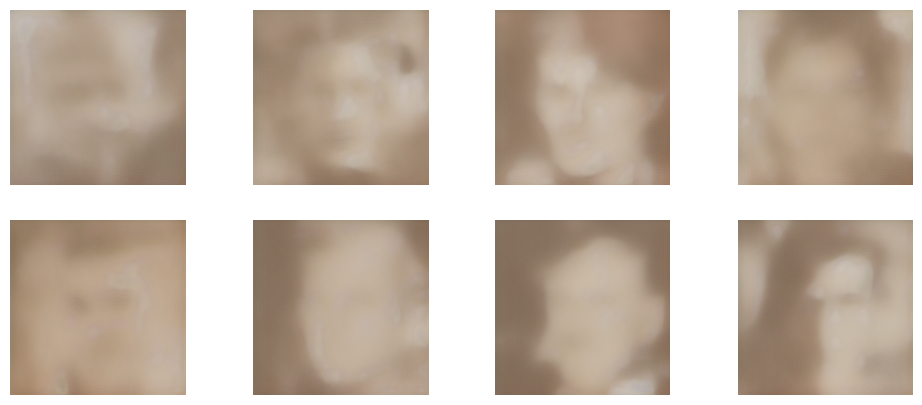

In [25]:
visualize(predicted_image['sample'].cpu().detach()/2+0.5, epoch=0, save=False, output_dir="./logs_mnist")